In [1]:
from obspy.clients.fdsn import Client
import math as M
from obspy import UTCDateTime
from datetime import datetime
import calendar
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
rs = Client(base_url='https://fdsnws.raspberryshakedata.com/')
iris = Client('IRIS')

In [12]:
def dt2ts(dt):
    """Converts a datetime object to UTC timestamp

    naive datetime will be considered UTC.

    """

    return calendar.timegm(dt.utctimetuple())

# function from https://docs.obspy.org/_modules/obspy/imaging/spectrogram.html#_nearest_pow_2:
def _nearest_pow_2(x):
    """
    Find power of two nearest to x

    >>> _nearest_pow_2(3)
    2.0
    >>> _nearest_pow_2(15)
    16.0

    :type x: float
    :param x: Number
    :rtype: Int
    :return: Nearest power of 2 to x
    """
    a = M.pow(2, M.ceil(np.log2(x)))
    b = M.pow(2, M.floor(np.log2(x)))
    if abs(a - x) < abs(b - x):
        return a
    else:
        return b

# traceplot/spectrogram function
def spec(data, figsize=(15,12), gain=10):
    '''
    Takes an obspy data stream
    
    Outputs a trace plot and spectrogram combined figure
    '''
    try:
        data = data.merge()[0]                      # merge all traces down to one (obspy likes to split them)
    except:
        data = data[0]                              # if that doesn't work, take the first one


    freq = data.stats.sampling_rate                 # sampling frequency in Hz of rshake (1D = 50; 3D & 4D = 100)
    start = data.stats.starttime
    end = data.stats.endtime
    seconds = end - start                           # timedelta containing number of seconds of data to display
    mplstart = dt2ts(data.times('utcdatetime')[0])
    mplend = dt2ts(data.times('utcdatetime')[-1])
    name = '%s.%s.%s.%s' % (data.stats.network, data.stats.station, data.stats.location, data.stats.channel)

    npts = data.stats.npts
    wlen = freq / 100
    per_lap = 0.9
    mult = 8.0

    
    nfft = int(_nearest_pow_2(wlen * freq))
    nlap = int(nfft * per_lap)
    mult = int(_nearest_pow_2(mult))
    mult = mult * nfft

    #initialize the graph and settings
    fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=figsize)

    ax1.set_xlim(0, npts)                           # being explicit here helps speed things up slightly
    ax1.set_ylim(min(data.data)-25, max(data.data)+25)

    if nfft > npts:
        nfft = int(_nearest_pow_2(npts / 8.0))
        nlap = int(nfft * per_lap)
    specgram = ax2.specgram(data.data, NFFT=nfft, pad_to=mult, Fs=freq, noverlap=nlap)[0] # take only the spectrogram
    specgram = np.flipud(specgram**(1/gain))        # flip and apply nth root gain
    
    # Create your x-limits. Using two of your unix timestamps you first
    # create a list of datetime.datetime objects using map.
    x_lims = list(map(datetime.utcfromtimestamp, [mplstart, mplend]))

    # You can then convert these datetime.datetime objects to the correct
    # format for matplotlib to work with.
    x_lims = mdates.date2num(x_lims)
    
    ax1.set(title='%s - %s - %s - %sHz' % (name, start, end, freq), ylabel='Counts')
    ax1.plot(data, 'k-', linewidth=0.5)

    ax2.set(xlabel='UTC Date / Time', ylabel='Frequency (Hz)')
    ax2.imshow(specgram, interpolation='nearest', extent=[x_lims[0], x_lims[1],  0, freq/2], aspect='auto')

    #ax1.xaxis_date()
    ax2.xaxis_date()
    date_format = mdates.DateFormatter('%Y.%j - %H:%M:%S')
    ax2.xaxis.set_major_formatter(date_format)
    fig.autofmt_xdate()

    plt.show()

# Event query (example: quarry blast in Bucksport, ME)

In [22]:
start_1 = "2018-06-27 16:00:00"
end_1 = "2018-06-27 16:01:00"
starttime = UTCDateTime(start_1)
endtime = UTCDateTime(end_1)

#### R4989 (in seismic vault), Orono, ME

/home/iannesbitt/anaconda3/envs/obspy/lib/python3.6/site-packages/obspy/signal/detrend.py:31: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(data.dtype, float):


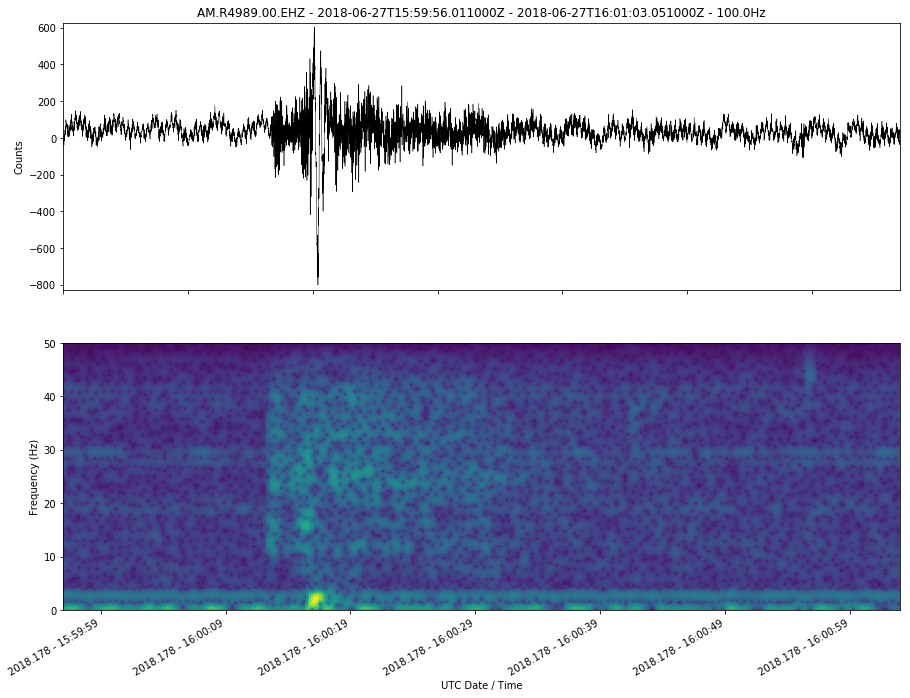

In [14]:
q1 = rs.get_waveforms('AM', 'R4989', '00', 'EHZ', starttime, endtime)
f = q1.merge()
f = f.detrend()
spec(f, gain=6)

#### RB489, Pigeon Hill, ME

/home/iannesbitt/anaconda3/envs/obspy/lib/python3.6/site-packages/obspy/signal/detrend.py:31: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(data.dtype, float):


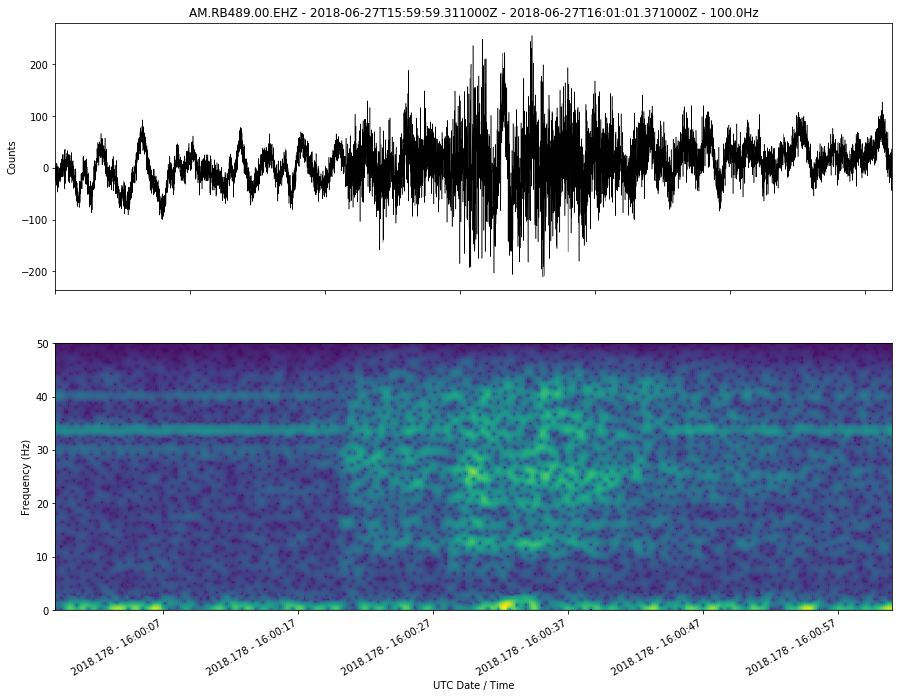

In [15]:
q2 = rs.get_waveforms('AM', 'RB489', '00', 'EHZ', starttime, endtime)
f = q2.merge()
f = f.detrend()
spec(f, gain=6)

#### US.PKME, Peaks-Kenny, ME

/home/iannesbitt/anaconda3/envs/obspy/lib/python3.6/site-packages/obspy/signal/detrend.py:31: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(data.dtype, float):


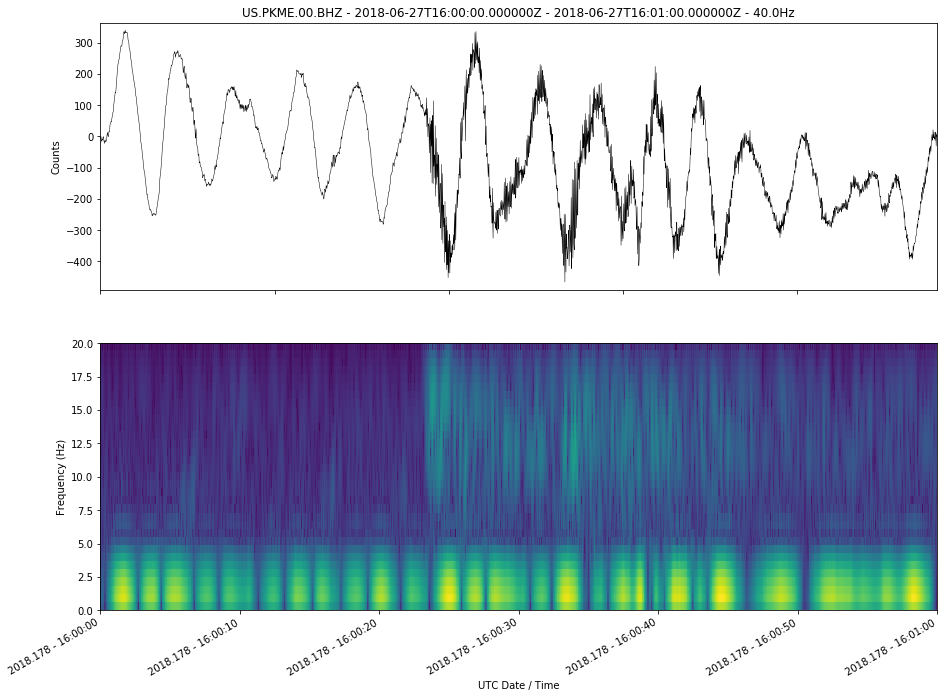

In [16]:
q3 = iris.get_waveforms('US', 'PKME', '00', 'BHZ', starttime, endtime)
f = q3.merge()
f = f.detrend()
spec(f, gain=6)